<a href="https://colab.research.google.com/github/Alex112525/LangGraph-notebooks/blob/main/Sub_graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install langgraph langgraph-sdk langgraph-checkpoint-sqlite langsmith langchain-community langchain-core langchain-openai tavily-python wikipedia

In [2]:
import os
import operator
from datetime import datetime
from typing import Any, Annotated, List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

from google.colab import userdata
from IPython.display import Image, display, Markdown

In [3]:
from langchain_core.tools import tool
from langchain_core.documents import Document
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, ToolMessage
from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.utils.function_calling import convert_to_openai_function
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser

from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

In [4]:
from langchain_openai import AzureChatOpenAI
from langchain_community.retrievers import TavilySearchAPIRetriever

In [5]:
os.environ["AZURE_OPENAI_API_KEY"] = userdata.get('Azure_openai')
os.environ["AZURE_OPENAI_ENDPOINT"] = userdata.get('Endpoint_openai')
os.environ["TAVILY_API_KEY"] = userdata.get('Tavily_API_key')

In [6]:
#LangSmith
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LangSmith')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Subgraphs"

## Utils Funtions

In [7]:
def get_model(model:str="DASH-mini", temp:float=0.1, max_tokens:int=100):
  """Get model from Azure OpenAI"""
  model = AzureChatOpenAI(
        openai_api_version="2024-02-15-preview",
        azure_deployment=model,
        temperature=temp,
        max_tokens=max_tokens,
    )
  return model

In [8]:
gpt_expert = get_model(max_tokens= 600)
gpt_beg = get_model(max_tokens= 600)
gpt_creator = get_model(max_tokens= 2000)

In [9]:
class keywords(BaseModel):
    """Answer with at least 5 keywords that you think are related to the topic"""
    Category: list = Field(description="list of at least 5 keywords related to the topic")

tagging_function = [convert_to_openai_function(keywords)]

gpt_keywords = get_model("DASH-mini",0, 50)
model_keywords = gpt_keywords.bind(functions=tagging_function, function_call={"name": "keywords"})
keywords_chain = ( model_keywords | JsonOutputFunctionsParser())

### Tools to search

In [10]:
@tool
def web_search(query:str) -> dict:
  """Retrieve docs from web search"""

  # Search
  print(datetime.now(), "- Start Web search")
  tavily_search = TavilySearchResults(max_results = 3)
  search_docs = tavily_search.invoke(query)

  # Format
  formatted_search_docs = "\n---\n".join(
      [f'<Document href={doc["url"]}/>\n{doc["content"]}\n </Document>' for doc in search_docs]
  )
  print(datetime.now(), "- End Web search")
  return {"context": [formatted_search_docs]}

In [11]:
@tool
def wiki_search(query: str) -> dict:
  """Retrieve documents from wikipedia"""

  # Search
  print(datetime.now(), "- Start Wiki search")
  search_docs = WikipediaLoader(query=query, load_max_docs=2).load()

  # Format
  formatted_search_docs = "\n---\n".join(
      [f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>' for doc in search_docs]
  )
  print(datetime.now(), "- End Wikipedia search")
  return {"context": [formatted_search_docs]}

In [12]:
wiki_search.invoke("attention")

2024-10-04 03:36:02.800755 - Start Wiki search
2024-10-04 03:36:07.724887 - End Wikipedia search


{'context': ['<Document source="https://en.wikipedia.org/wiki/Attention" page=""/>\nAttention or focus, is the concentration of awareness on some phenomenon to the exclusion of other stimuli. It is the selective concentration on discrete information, either subjectively or objectively. William James (1890) wrote that "Attention is the taking possession by the mind, in clear and vivid form, of one out of what seem several simultaneously possible objects or trains of thought. Focalization, concentration, of consciousness are of its essence." Attention has also been described as the allocation of limited cognitive processing resources. Attention is manifested by an attentional bottleneck, in terms of the amount of data the brain can process each second; for example, in human vision, less than 1% of the visual input data stream of 1MByte/sec can enter the bottleneck, leading to inattentional blindness.\nAttention remains a crucial area of investigation within education, psychology, neurosc

## Graphs

In [13]:
class Discussion(TypedDict):
  topic:  Annotated[list[str], operator.add]
  keywords:  Annotated[list[list], operator.add]
  expert:  Annotated[list, operator.add]
  search_expert: Annotated[list, operator.add]
  begginer:  Annotated[list, operator.add]
  search_begginer: Annotated[list, operator.add]
  discussion:  Annotated[list, operator.add]

### Build Sub-graphs

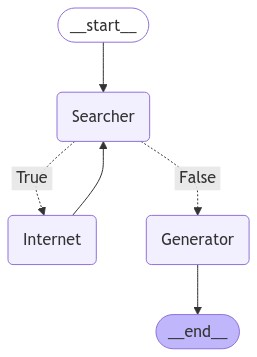

In [14]:
# Expert subgraph
prompt_research_exp ="""You are an expert researcher. Use the search engine to find information on the Internet about the topic and related keywords that can help complement your research.
You can make multiple calls whenever you want (together or in sequence).
Your goal is to provide all the relevant information that you found, remember that you are an expert and be accurate."""

prompr_generator_exp = """You are an expert in creating articles, create one with the following topic and context in less than 600 words"""
# funtions
def generate_expert(state: Discussion):
  topic = state['topic']
  messages = [SystemMessage(content=prompr_generator_exp)] + [HumanMessage(content= "Topic: " + topic[0])] + state['search_expert']
  message = model_exp.invoke(messages)
  return {'expert': [message.content]}

def call_expert(state: Discussion):
  topic = state['topic']
  if state["search_expert"]:
    messages = [SystemMessage(content=prompt_research_exp)] + [HumanMessage(content="Topic: " + topic[0])] + [AIMessage(content="Keywords: " + ", ".join(state["keywords"][0]) )] + state['search_expert']
  else:
    messages = [SystemMessage(content=prompt_research_exp)] + [HumanMessage(content="Topic: " + topic[0])] + [AIMessage(content="Keywords: " + ", ".join(state["keywords"][0]) )]
  message = model_exp.invoke(messages)
  return {'search_expert': [message]}

def take_action_exp(state: Discussion):
  tool_calls = state['search_expert'][-1].tool_calls
  results = []
  for t in tool_calls:
    print(f"Calling: {t}")
    result = tools_exp[t['name']].invoke(t['args'])
    results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
  return {'search_expert': results}

def need_to_search_exp(state: Discussion):
  result = state['search_expert'][-1]
  return len(result.tool_calls) > 0
# tools
tool_exp = [web_search]
tools_exp = {t.name: t for t in tool_exp}
model_exp = gpt_expert.bind_tools(tool_exp)

# Add nodes
builder_exp = StateGraph(Discussion)

builder_exp.add_node("Internet", take_action_exp)
builder_exp.add_node("Searcher", call_expert)
builder_exp.add_node("Generator", generate_expert)

# Flow
builder_exp.add_edge(START, "Searcher")
builder_exp.add_edge("Internet", "Searcher")
builder_exp.add_edge("Generator", END)
builder_exp.add_conditional_edges("Searcher", need_to_search_exp, {True:"Internet", False: "Generator" })

graph_exp = builder_exp.compile()

display(Image(graph_exp.get_graph().draw_mermaid_png()))

In [15]:
result_exp = graph_exp.invoke({"topic":[ "What is Attention in human cognition"], "keywords": ["psychology", "cognition", "Attention"]})

Calling: {'name': 'web_search', 'args': {'query': 'Attention in human cognition psychology'}, 'id': 'call_Jz9gLzVtIrsNh9GWPIsgH149', 'type': 'tool_call'}
2024-10-04 03:36:09.487903 - Start Web search
2024-10-04 03:36:12.248155 - End Web search


In [16]:
display(Markdown(result_exp["expert"][0]))

### Attention in Human Cognition: An Overview

Attention is a fundamental cognitive process that enables individuals to focus on specific stimuli while filtering out irrelevant information. This selective focus is crucial for navigating our complex environments, allowing us to prioritize tasks and manage cognitive resources effectively.

#### Definition and Significance

William James, a pioneering psychologist, described attention as "the taking possession by the mind, in clear and vivid form, of one out of what may seem several simultaneously possible objects or trains of thought." This definition highlights the essence of attention: it involves a conscious choice to engage with certain stimuli while withdrawing from others. This selective nature of attention is vital for effective functioning in daily life, influencing everything from learning to decision-making.

#### Types of Attention

1. **Selective Attention**: This type allows individuals to focus on a particular stimulus while ignoring distractions. For example, listening to a friend in a noisy café requires selective attention to filter out background chatter.

2. **Sustained Attention**: Also known as vigilance, this refers to the ability to maintain focus on a task over an extended period. It is essential for activities like studying or monitoring a process.

3. **Divided Attention**: This involves processing multiple sources of information simultaneously, such as talking on the phone while driving. However, divided attention often leads to decreased performance in one or more tasks.

#### Cognitive Mechanisms

Attention is supported by various brain regions, particularly the frontal and parietal cortices. The anterior cingulate cortex is a key player in executive attention, which involves managing and directing attentional resources. This neural architecture allows for the flexibility and adaptability of attention, enabling individuals to switch focus as needed.

#### Factors Influencing Attention

Several factors can impact attentional capacity:

- **Interest and Motivation**: Higher levels of interest in a task can enhance focus and engagement. For instance, students are more likely to pay attention in subjects they find intriguing.

- **Distractions**: Both external distractions (like noise) and internal distractions (such as wandering thoughts) can significantly hinder attention. Managing these distractions is crucial for maintaining focus.

- **Cognitive Load**: The amount of information being processed can affect attention. High cognitive load can overwhelm attentional resources, leading to decreased performance.

#### Applications and Theories

Understanding attention is essential for various fields, including psychology, education, and cognitive neuroscience. Theories of attention help explain how individuals manage cognitive resources in complex environments, particularly in situations of information overload. These theories can inform strategies to enhance attention, such as mindfulness practices and structured learning environments.

#### Conclusion

Attention is a vital cognitive function that shapes our perception and interaction with the world. By understanding its mechanisms and types, we can develop better strategies for enhancing focus and managing distractions, ultimately improving our cognitive performance in various aspects of life.

For further exploration, consider these resources:
- [Verywell Mind on Attention](https://www.verywellmind.com/what-is-attention-279500

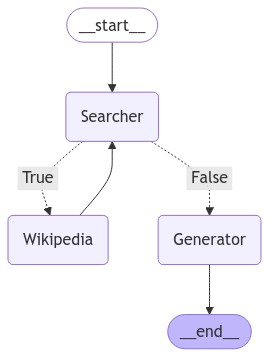

In [17]:
# Begginer subgraph
prompt_research_beg ="""You are a novice researcher with a desire to learn more; use the search engine to find information on the topic.
You can make multiple calls whenever you want (together or in sequence).
Your goal is to provide all the relevant information you have found about topic."""

prompr_generator_beg = """You are and novice researcher, create an speech with the following topic and context, ask questions like if you want to learn more about and invite others to learn, use less than 600 words."""
# funtions
def generate_beg(state: Discussion):
  topic = state['topic']
  messages = [SystemMessage(content=prompr_generator_beg)] + [HumanMessage(content="Topic: " + topic[0])] + state['search_begginer']
  message = gpt_beg.invoke(messages)
  return {'begginer': [message.content]}

def call_beg(state: Discussion):
  topic = state['topic']
  if state["search_begginer"]:
    messages = [SystemMessage(content=prompt_research_beg)] + [HumanMessage(content="Topic: " + topic[0])] + state['search_begginer']
  else:
    messages = [SystemMessage(content=prompt_research_beg)] + [HumanMessage(content="Topic: " + topic[0])]
  message = model_beg.invoke(messages)
  return {'search_begginer': [message]}

def take_action_beg(state: Discussion):
  tool_calls = state['search_begginer'][-1].tool_calls
  results = []
  for t in tool_calls:
    print(f"Calling: {t}")
    result = tools_beg[t['name']].invoke(t['args'])
    results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
  return {'search_begginer': results}

def need_to_search_beg(state: Discussion):
  result = state['search_begginer'][-1]
  return len(result.tool_calls) > 0

# tools
tool_beg = [wiki_search]
tools_beg = {t.name: t for t in tool_beg}
model_beg = gpt_beg.bind_tools(tool_beg)

# Add nodes
builder_beg = StateGraph(Discussion)

builder_beg.add_node("Wikipedia", take_action_beg)
builder_beg.add_node("Searcher", call_beg)
builder_beg.add_node("Generator", generate_beg)

# Flow
builder_beg.add_edge(START, "Searcher")
builder_beg.add_edge("Wikipedia", "Searcher")
builder_beg.add_edge("Generator", END)
builder_beg.add_conditional_edges("Searcher", need_to_search_beg, {True:"Wikipedia", False: "Generator" })

graph_beg = builder_beg.compile()

display(Image(graph_beg.get_graph().draw_mermaid_png()))

In [18]:
result_beg = graph_beg.invoke({"topic": ["What is Attention in human cognition"]})

Calling: {'name': 'wiki_search', 'args': {'query': 'Attention in human cognition'}, 'id': 'call_fc55HDfbVghp5xAAbu9XbpEx', 'type': 'tool_call'}
2024-10-04 03:36:20.273927 - Start Wiki search
2024-10-04 03:36:24.347865 - End Wikipedia search
Calling: {'name': 'wiki_search', 'args': {'query': 'Attention in psychology'}, 'id': 'call_5f4JzWz9S91GeqEUbZnD916L', 'type': 'tool_call'}
2024-10-04 03:36:24.776218 - Start Wiki search
2024-10-04 03:36:29.095043 - End Wikipedia search


In [19]:
display(Markdown(result_beg["begginer"][0]))

### Attention in Human Cognition

**Introduction**
Good [morning/afternoon/evening], everyone! Today, I want to explore a fascinating topic that affects us all: attention in human cognition. Attention is not just about what we focus on; it shapes our experiences, learning, and interactions with the world around us. 

**What is Attention?**
At its core, attention is the process of concentrating awareness on specific stimuli while filtering out others. William James, a pioneering psychologist, described it as the "taking possession by the mind" of one out of several possible objects or thoughts. This selective focus is crucial because our brains can only process a limited amount of information at any given time. 

**Why is Attention Important?**
Attention plays a vital role in our daily lives. It helps us prioritize information, manage tasks, and navigate complex environments. For instance, when you're in a crowded room, your ability to focus on a single conversation while ignoring background noise is a testament to your attentional skills. 

**Mechanisms of Attention**
Let’s delve into some key concepts related to attention:

1. **Selective Attention**: This is our ability to focus on a particular object or task while ignoring distractions. Think about how you can read a book in a busy café; that’s selective attention at work!

2. **Inattentional Blindness**: Have you ever missed something obvious in your surroundings because you were focused on something else? This is known as inattentional blindness, where we fail to notice unexpected stimuli when our attention is directed elsewhere.

3. **Cognitive Resources**: Our brains have limited cognitive resources, meaning we can only process a small fraction of the information we encounter. This limitation necessitates prioritizing certain stimuli over others.

**Research and Applications**
Attention is a significant area of study across various fields, including psychology, neuroscience, and education. Researchers are investigating how sensory cues influence attention and how attention interacts with other cognitive processes like memory. 

Modern technologies, such as functional magnetic resonance imaging (fMRI), have allowed scientists to explore the neural networks involved in attention. This research has profound implications for understanding learning, mental health, and even artificial intelligence.

**Cultural Variations**
Interestingly, attention can vary across cultures. Different cultural contexts can influence how individuals allocate their attention and process information. This raises intriguing questions about how our environments shape our cognitive processes.

**Historical Context**
The study of attention has evolved significantly over time. Early philosophers, like Plato and Descartes, speculated about the nature of the mind. In the 20th century, cognitive psychology emerged, moving away from behaviorism, which largely ignored mental processes. This shift has led to a deeper understanding of attention and its complexities.

**Conclusion**
In conclusion, attention is a fundamental aspect of human cognition that influences how we experience and interact with the world. By understanding its mechanisms and implications, we can enhance educational practices, improve mental health interventions, and even inform

### Main graph

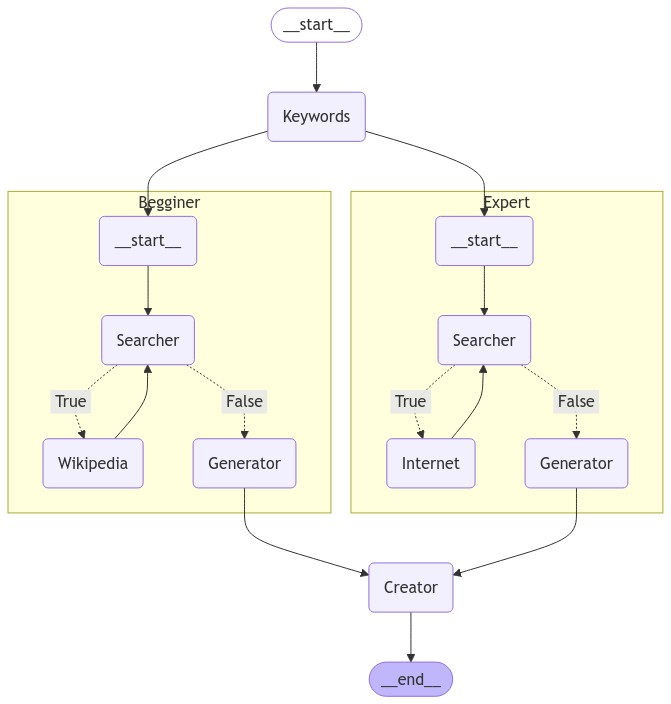

In [20]:
# Main graph
prompt_diss = """ Your task is to create a discussion paper between the two following articles, one from an expert and the other from a beginner researcher.
Try to make it interesting with questions-answers and the opinion of the two people, be accurate and use less than 1100 words. """

# Functions
def search_for_keywords(state: Discussion):
  topic = state['topic']
  messages = [SystemMessage(content="Give me all the keywords related to the following topic")] + [HumanMessage(content="Topic: " + topic[0])]
  message = keywords_chain.invoke(messages)
  print(message["Category"])
  return {'keywords': [message["Category"]]}

def generate_disscusion(state: Discussion):
  print("Generating...")
  messages = [SystemMessage(content=prompt_diss)] + [HumanMessage(content="Expert researcher: " + state["expert"][0])] + [HumanMessage(content="Begginer researcher: " + state["begginer"][0])]
  message = gpt_creator.invoke(messages)
  return {'discussion': [message.content]}
# Add nodes

main_builder = StateGraph(Discussion)

main_builder.add_node("Expert", graph_exp)
main_builder.add_node("Begginer",  graph_beg)
main_builder.add_node("Keywords", search_for_keywords)
main_builder.add_node("Creator", generate_disscusion)

# Flow
main_builder.add_edge(START, "Keywords")
main_builder.add_edge("Keywords", "Expert")
main_builder.add_edge("Keywords", "Begginer")
main_builder.add_edge("Expert", "Creator")
main_builder.add_edge("Begginer", "Creator")
main_builder.add_edge("Creator", END)

graph_main = main_builder.compile()

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(graph_main.get_graph(xray=1).draw_mermaid_png()))

In [21]:
result_main = graph_main.invoke({"topic": ["What is Attention in human cognition"]})

['Cognition', 'Psychology', 'Neuroscience', 'Attention', 'Perception']
Calling: {'name': 'wiki_search', 'args': {'query': 'Attention in human cognition'}, 'id': 'call_BOc17nseiA3RqBwlI1aMhoqY', 'type': 'tool_call'}
2024-10-04 03:36:38.578486 - Start Wiki search
Calling: {'name': 'web_search', 'args': {'query': 'Attention in human cognition psychology neuroscience'}, 'id': 'call_0E0LwACyEHSJjgFpIGqjSGNh', 'type': 'tool_call'}
2024-10-04 03:36:39.161166 - Start Web search
2024-10-04 03:36:42.525197 - End Wikipedia search
2024-10-04 03:36:44.226908 - End Web search
Calling: {'name': 'web_search', 'args': {'query': 'definition of attention in psychology and neuroscience'}, 'id': 'call_BOc17nseiA3RqBwlI1aMhoqY', 'type': 'tool_call'}
2024-10-04 03:37:11.327803 - Start Web search
2024-10-04 03:37:14.806924 - End Web search
Calling: {'name': 'web_search', 'args': {'query': 'types of attention in human cognition'}, 'id': 'call_kC50Tp4nJIf39IqdRVGnPvGw', 'type': 'tool_call'}
2024-10-04 03:37:14.

In [22]:
display(Markdown(result_main["discussion"][0]))

### Discussion Paper: Attention in Human Cognition

**Participants:**
- **Expert Researcher (ER)**
- **Beginner Researcher (BR)**

---

**BR:** Good [morning/afternoon/evening], everyone! Today, I want to explore a fascinating topic that affects our daily lives: attention in human cognition. Have you ever wondered why you can focus on a conversation in a noisy room or why you sometimes miss things right in front of you? 

**ER:** Absolutely! Those experiences are indeed tied to the concept of attention. As William James noted, attention is about focusing our mental resources on what matters most at any given moment. It’s a fundamental cognitive process.

**BR:** I find it intriguing that attention can be categorized into different types. You mentioned selective, sustained, divided, and alternating attention. Can you elaborate on how these types interact in real-life situations?

**ER:** Certainly! In real life, these types of attention often overlap. For instance, when you're studying (sustained attention), you might also need to switch tasks (alternating attention) if you receive a text message. The ability to manage these types effectively is crucial for cognitive performance.

**BR:** That makes sense! I also came across the concept of the "attentional bottleneck." It’s fascinating that our brains can only process a limited amount of information at any given time. Can you explain how this bottleneck affects our perception?

**ER:** The attentional bottleneck indeed limits our cognitive resources. For example, in visual perception, less than 1% of visual input can enter this bottleneck. This limitation can lead to phenomena like inattentional blindness, where we fail to notice unexpected stimuli. It highlights the selective nature of attention—what we focus on shapes our perception of reality.

**BR:** I’ve experienced inattentional blindness myself! It’s surprising how often we miss things right in front of us. I also read that research techniques like PET and fMRI have been used to study attention. How do these technologies enhance our understanding?

**ER:** These imaging techniques allow us to observe brain activity in real-time. They help identify the frontoparietal attention network, which is crucial for controlling attention. By understanding how different brain regions interact during attentional tasks, we can gain insights into cognitive processes and disorders related to attention.

**BR:** That’s fascinating! I also found it interesting that attention can vary across cultures. How do cultural backgrounds influence attention?

**ER:** Cultural variations in attention can significantly affect how individuals focus on tasks and perceive stimuli. For instance, collectivist cultures may emphasize group dynamics, leading to a more holistic attention style, while individualistic cultures may focus on specific details. This raises questions about how our environments shape cognitive processes.

**BR:** That’s a thought-provoking point! I wonder how these cultural differences might impact educational approaches. Do you think understanding attention can help improve learning strategies?

**ER:** Absolutely! Tailoring educational strategies to accommodate different attentional styles can enhance learning outcomes. For example, incorporating group activities in collectivist cultures may foster better engagement, while individual tasks might be more effective in individualistic settings.

**BR:** Speaking of engagement, I’m curious about the philosophical implications of attention. How does the relationship between attention and consciousness influence our understanding of mental health?

**ER:** The relationship between attention and consciousness is indeed profound. Attention acts as a gatekeeper for conscious experience. Disruptions in attentional processes can lead to mental health issues, such as anxiety or ADHD. Understanding this relationship can inform therapeutic approaches and interventions.

**BR:** That’s a crucial insight! It seems that attention plays a role not just in cognition but also in our overall well-being. How do you think advancements in artificial intelligence might relate to our understanding of attention?

**ER:** AI systems often mimic human attention processes, such as selective attention in image recognition. Understanding human attention can inform the development of more sophisticated AI that can better interact with humans. This relationship raises ethical questions about the implications of AI in our daily lives.

**BR:** It’s fascinating to think about how attention connects so many different fields! In conclusion, attention is a complex and multifaceted cognitive process that plays a crucial role in our daily lives. 

**ER:** Indeed! As we continue to explore attention, we uncover its significance in various domains, from education to mental health and even technology. The more we understand, the better we can navigate our cognitive landscape.

**BR:** Thank you for this enlightening discussion! I look forward to diving deeper into this topic and exploring its implications further.

**ER:** My pleasure! Let’s keep the conversation going as we both continue our research journeys.

--- 

This dialogue highlights the complexities of attention in human cognition, bridging the gap between expert knowledge and beginner curiosity while encouraging further exploration of the topic.

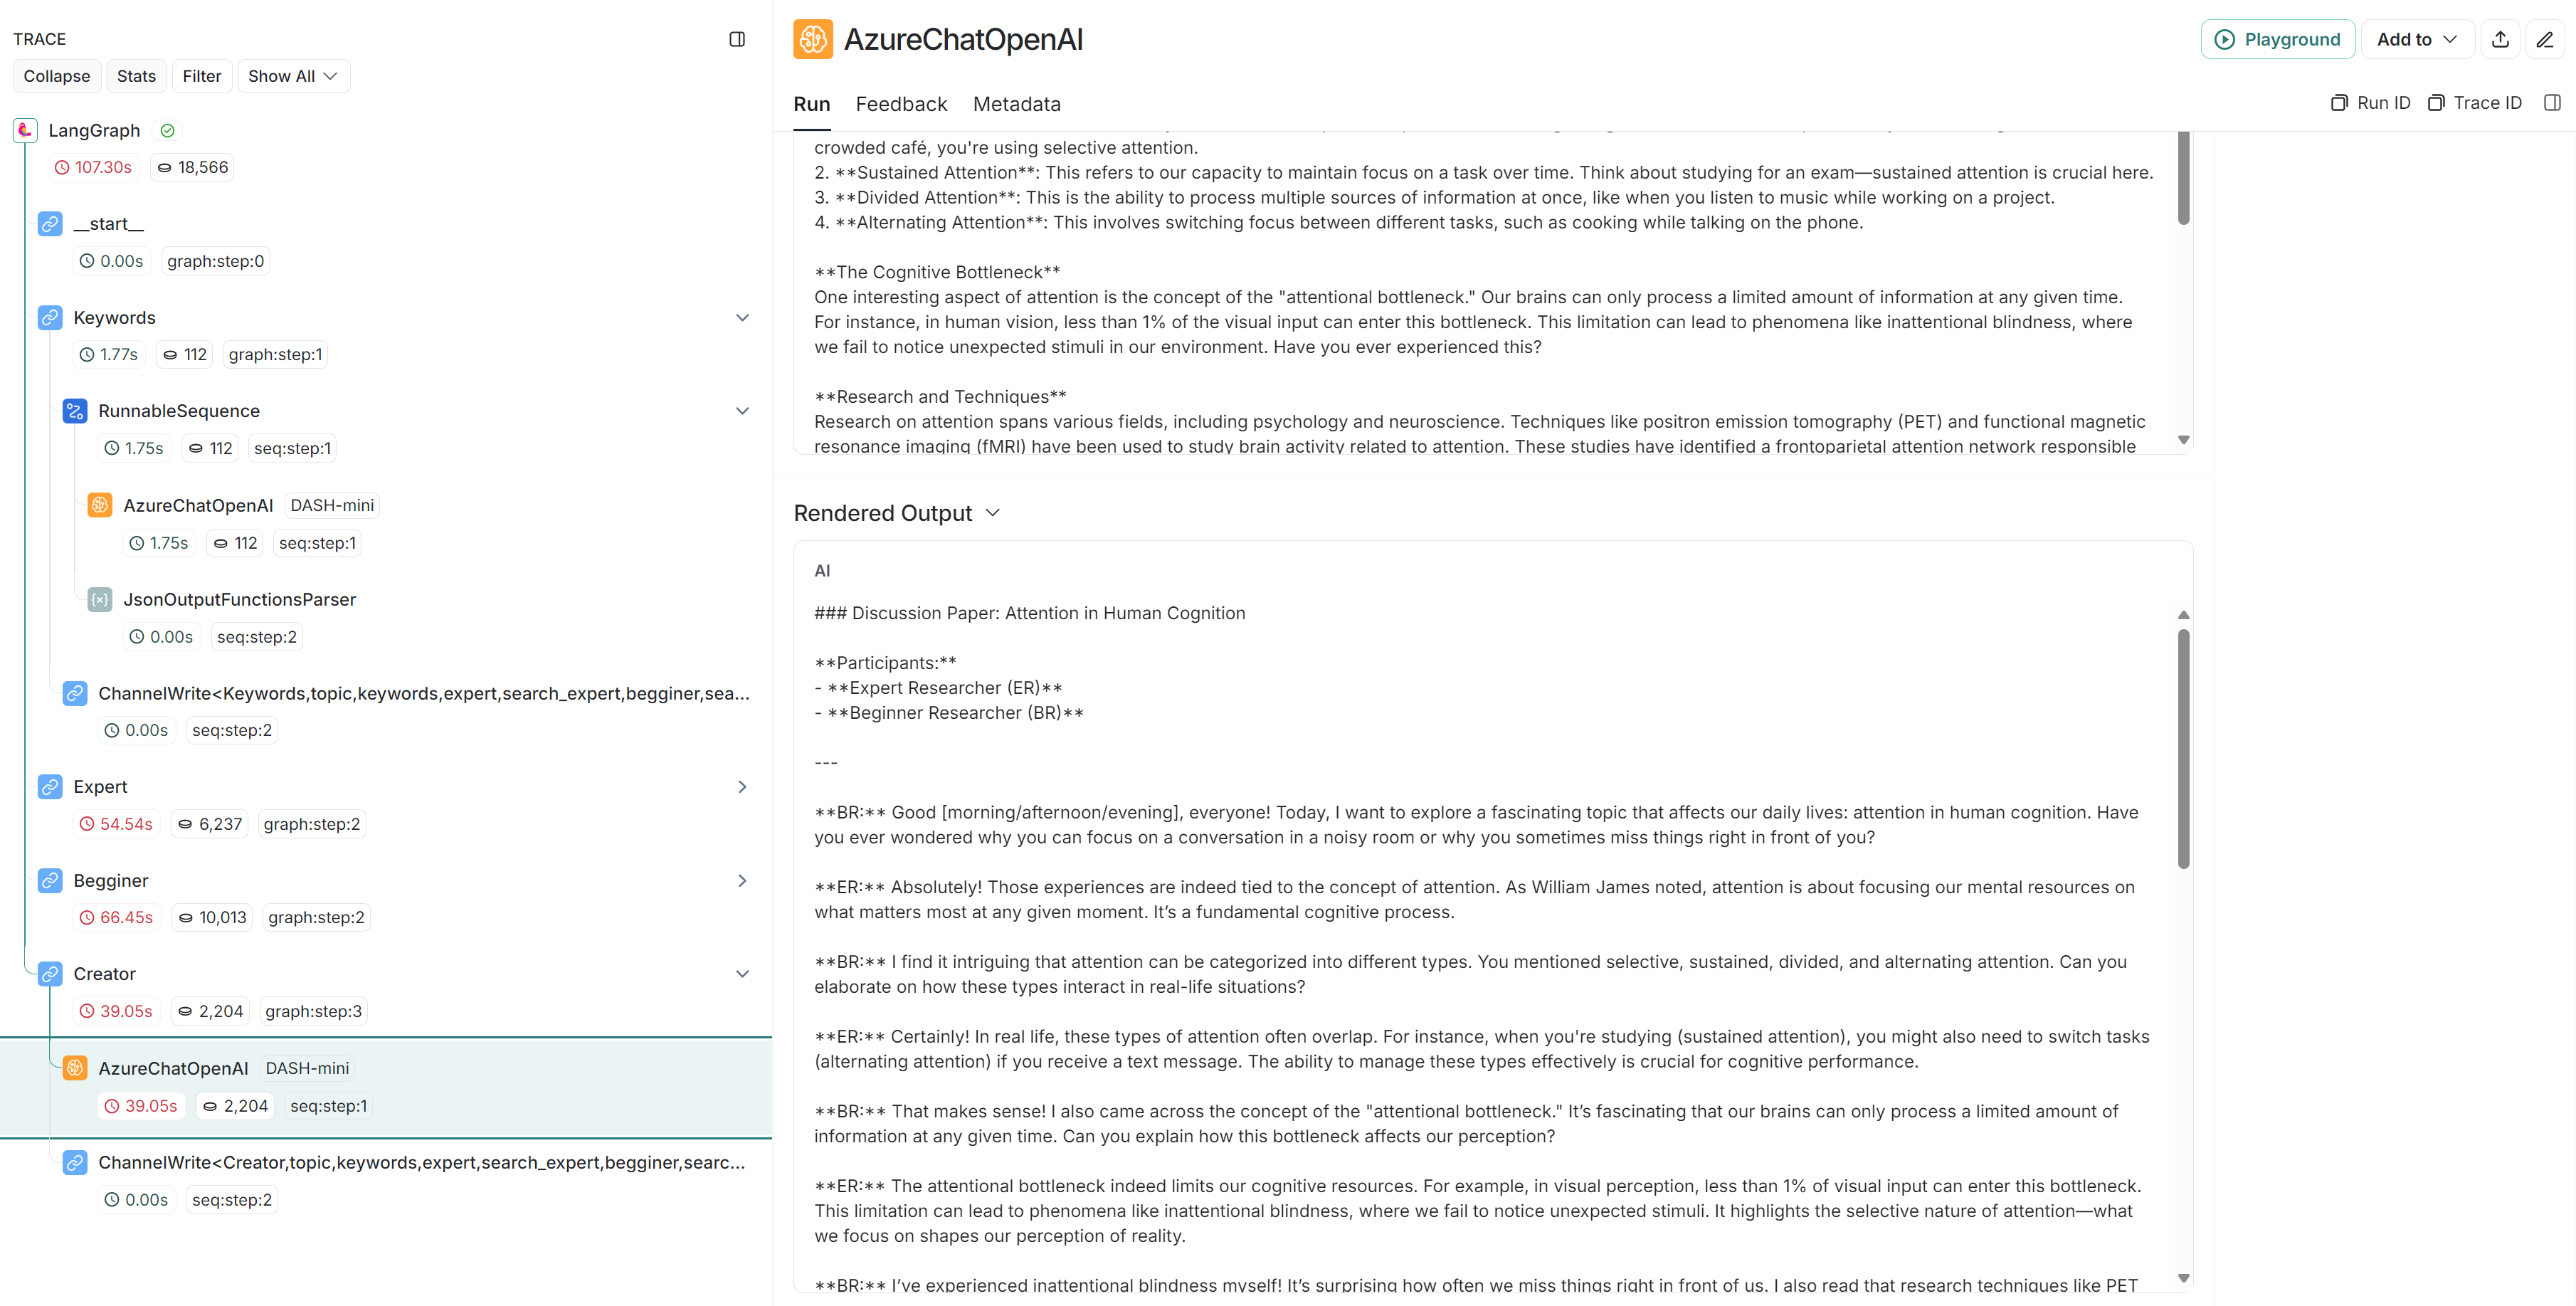